# PSD plots

Loads depth-frequency-time PSD data and then plots for various circumstances.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2
from scipy.optimize import curve_fit
for i in range(2):
    %matplotlib notebook

In [92]:
# import data

adcp = 'Axis55'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2018

ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')
n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds)

In [93]:
# extract plotting variables & GM

t_stamp = int(ds[0].t_stamp)
depth = ds[0].depth.values
f = ds[0].specf.values

# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')   # get GM data from separate code
gm_freq = gm[:,0]                                # GM based on N at -904 m
gm_psd = gm[:,1]

In [94]:
# select and average time

# set date range

start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

dt_list,phi_u,phi_v = [],[],[]
for i in range(n_seg):
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_list.append(ds[i].spect[j].values)
            phi_u.append(ds[i].Sxxu[:,:,j])                 # time segment, [depth, freq]
            phi_v.append(ds[i].Sxxv[:,:,j])
avg_u = sum(phi_u)/len(dt_list)
avg_v = sum(phi_v)/len(dt_list)
            
print("Output time range:",dt_list[0],'to',dt_list[-1])     # print to check desired interval

Output time range: 2018-01-06T08:07:30.000000000 to 2018-12-15T00:37:29.000000000


## Depth specific PSD (annual)

In [95]:
# WKB scale and select depth

WKB_u = avg_u / ds[0].WKB_scale
WKB_v = avg_v / ds[0].WKB_scale

if adcp == 'Slope':
    didx = -24           # -9 for lower depth (-315), -24 for mid-depth (-195)
elif adcp == 'Axis75':
    didx = -22           # -7 for lower depth (-920), -22 for mid-depth (-800)
elif adcp == 'Axis55':
    didx = -10           # -4 for lower depth (-913), -10 for mid-depth (-793)
    
u = WKB_u[didx,:].values         
v = WKB_v[didx,:].values
d_stamp = ds[0].depth[didx].values

#depth_u = WKB_u.mean(dim='depth')
#depth_v = WKB_v.mean(dim='depth')

print('Depth:',-d_stamp,'m')

Depth: -793 m


In [96]:
# error bars (95% confidence intervals) for each depth

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = ds[0].t / (ds[0].nps / 2)                # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

u_lower = u * cint[0]             # define upper and lower confidence values
u_upper = u * cint[1]
v_lower = v * cint[0]             # define upper and lower confidence values
v_upper = v * cint[1]

In [97]:
# continuum fits (7e-5 to 1.2e-4 Hz)

lowf = 64                    # set frequency range for continuum
highf = 112

f_range = f[lowf:highf]      # set data range for continuum
u_range = u[lowf:highf]
v_range = v[lowf:highf]

def power_law(x,a,b):        # power law
    return a*np.power(x,b)

# Fit the power-law data
upars, ucov = curve_fit(f=power_law, xdata=f_range, ydata=u_range, p0=[1e-8, -2])
vpars, vcov = curve_fit(f=power_law, xdata=f_range, ydata=v_range, p0=[1e-8, -2])
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
ustdevs = np.sqrt(np.diag(ucov))
vstdevs = np.sqrt(np.diag(vcov))
# Calculate the residuals
ures = u_range - power_law(f_range, *upars)
vres = v_range - power_law(f_range, *vpars)

ua = upars[0]       # get a and b coefficients
ub = upars[1]
va = vpars[0]
vb = vpars[1]

In [ ]:
# plot PSD

fig, ax = plt.subplots(1,1,figsize=(8,7))

ax.axvline(1.161e-5, color ='grey',lw=1,alpha=0.8) # constituents
ax.axvline(1.732e-5, color ='grey', lw=1)    
ax.axvline(2.236e-5, color ='grey',lw=1)
ax.axvline(3.968e-5, color ='grey',lw=1)
ax.axvline(4.472e-5, color ='grey',lw=1)
ax.axvline(6.709e-5, color ='grey',lw=1)
ax.axvline(4.026e-4, color ='grey',lw=1)
fig.text(0.38,0.17,'K$_1$',fontsize=14)
fig.text(0.442,0.17,'$f$',fontsize=14)
fig.text(0.459,0.17,'M$_2$',fontsize=14)
fig.text(0.522,0.17,'$f$M$_2$',fontsize=14)
fig.text(0.58,0.17,'M$_4$',fontsize=14)
fig.text(0.632,0.17,'M$_6$',fontsize=14)
fig.text(0.86,0.17,'N',fontsize=14)
fig.text(0.125,0.89,'WKB-scaled',fontsize=14)
fig.text(0.38,0.89,f'-{d_stamp} m - {adcp} - {t_stamp}',fontsize=14)

x_diurnal = [1.08e-5,1.30e-5]
x_inertial = [1.52e-5,1.95e-5]
x_semidiurnal = [2.17e-5,2.39e-5]
y_up = [1e4,1e4]
y_down = [1e-3,1e-3]
ax.fill_between(x_diurnal,y_up,y_down,color='green',alpha=0.2)
ax.fill_between(x_inertial,y_up,y_down,color='green',alpha=0.2)
ax.fill_between(x_semidiurnal,y_up,y_down,color='green',alpha=0.2,label='Int. range')

ax.set_ylim(1e-2,3e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 

ax.tick_params(axis='both', direction='in', which='both', labelsize=14)
ax.set_ylabel('Power spectral density [(m/s)$^2$/Hz]',fontsize=14)
ax.set_xlabel('Frequency [Hz]',fontsize=14)

if adcp == 'Axis75' or adcp == 'Slope':
    ax.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
elif adcp == 'Axis55':
    ax.axhline(0.53,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
    
ax.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='black',lw=1.2,ls='--', label='GM79: 1/2') # 1/2 GM for components

if adcp == 'Slope':
    ax.loglog(f, u, label='Cross-slope',color='blue')
    ax.loglog(f, v, label='Along-slope',color='red')
elif adcp == 'Axis55' or adcp == 'Axis75':
    ax.loglog(f, u, label='Cross-canyon',color='blue')
    ax.loglog(f, v, label='Along-canyon',color='red')

ax.fill_between(f, u_lower, u_upper, facecolor='blue', alpha=0.2)
ax.fill_between(f, v_lower, v_upper, facecolor='red', alpha=0.2,label='95% conf.')

ax.loglog(f_range,ua*f_range**ub,color='black',lw=3)
ax.loglog(f_range,va*f_range**vb,color='black',lw=3)

if adcp == 'Slope':
    fig.text(0.14,0.40,r'Cross-slope $af^b$:',fontsize=13)
    fig.text(0.14,0.28,r'Along-slope $af^b$:',fontsize=13)
elif adcp == 'Axis75' or adcp == 'Axis55':
    fig.text(0.14,0.40,r'Cross-canyon $af^b$:',fontsize=13)
    fig.text(0.14,0.28,r'Along-canyon $af^b$:',fontsize=13)
fig.text(0.14,0.36,'a = {:.2e}'.format(ua),fontsize=13)
fig.text(0.14,0.32,'b = %.2f'%ub,fontsize=13)
fig.text(0.14,0.24,'a = {:.2e}'.format(va),fontsize=13)
fig.text(0.14,0.20,'b = %.2f'%vb,fontsize=13)

#fig.tight_layout()
plt.legend(loc=[0.665,0.70],frameon=False,fontsize=13)
plt.show()

plt.savefig(fname=f'./plots/psd_plots/psd_{adcp}_{d_stamp}_{t_stamp}.pdf',format='pdf')

## Inter-annual comparison

In [75]:
# save annual data to .nc file

ds_out = xr.Dataset( 
    data_vars=dict(
        u=(['f'], u),    # PSD data
        v=(['f'], v),
    ),
    coords=dict(
        f=f,              
    ),
    attrs=dict(
        description=f'PSD data from {adcp} for {t_stamp}.',
        d_stamp = d_stamp,
    ),
) 
ds_out.to_netcdf(f'../Data/interannual/psd_{adcp}_{t_stamp}.nc')

<IPython.core.display.Javascript object>


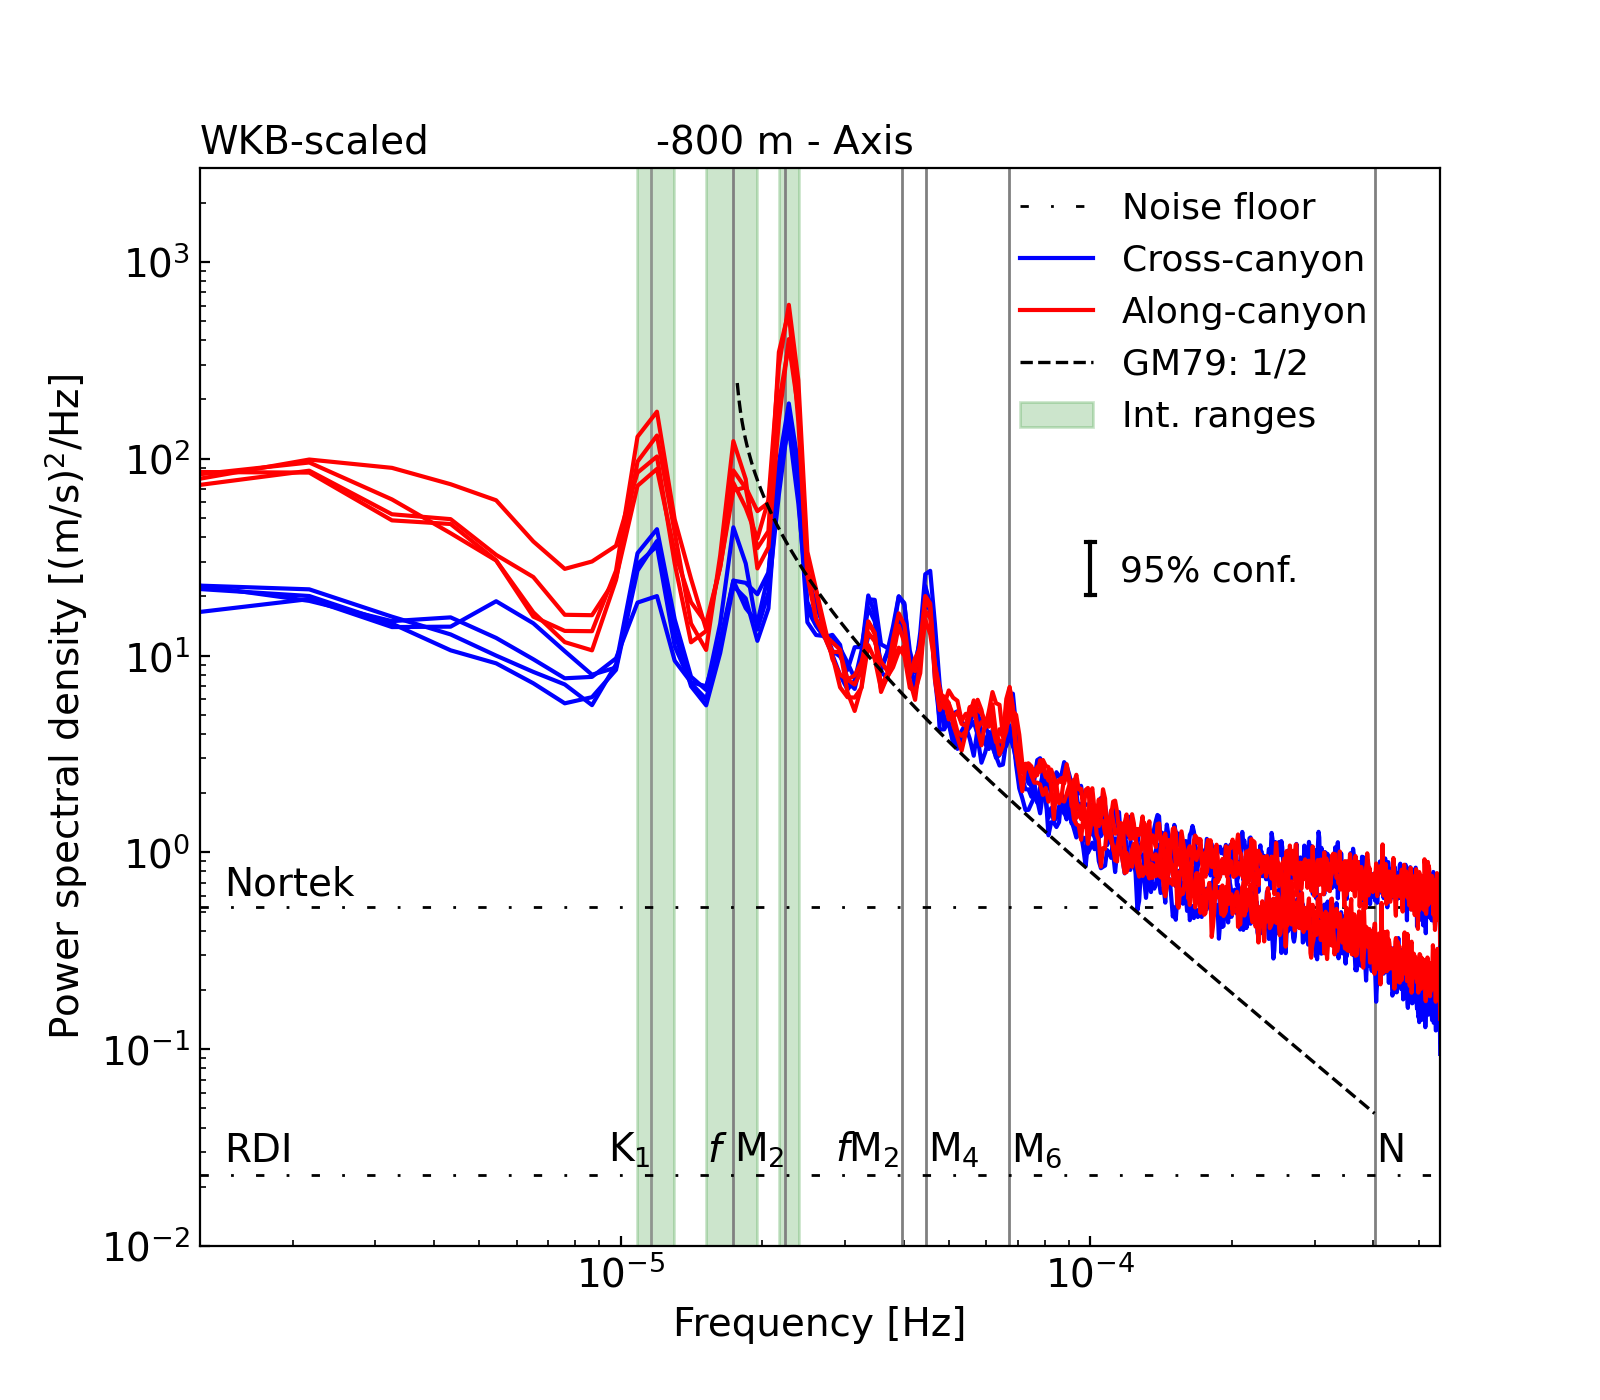

In [99]:
# plot multi-annual data

multi_adcp = 'Axis'       # Slope or Axis
if multi_adcp == 'Slope':
    ds0 = xr.open_dataset(f'../Data/interannual/psd_Slope_2013.nc')
    ds1 = xr.open_dataset(f'../Data/interannual/psd_Slope_2014.nc')
    ds2 = xr.open_dataset(f'../Data/interannual/psd_Slope_2017.nc')
    ds3 = xr.open_dataset(f'../Data/interannual/psd_Slope_2018.nc')
elif multi_adcp == 'Axis':
    ds0 = xr.open_dataset(f'../Data/interannual/psd_Axis75_2013.nc')
    ds1 = xr.open_dataset(f'../Data/interannual/psd_Axis75_2014.nc')
    ds2 = xr.open_dataset(f'../Data/interannual/psd_Axis55_2017.nc')
    ds3 = xr.open_dataset(f'../Data/interannual/psd_Axis55_2018.nc')
    
multi_u = (ds0.u + ds1.u + ds2.u + ds3.u) / 4
multi_v = (ds0.v + ds1.v + ds2.v + ds3.v) / 4

# error bars (95% confidence intervals) for each depth

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = ds[0].t / (ds[0].nps / 2)                # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

multi_u_lower = multi_u * cint[0]             # define upper and lower confidence values
multi_u_upper = multi_u * cint[1]          
multi_v_lower = multi_v * cint[0]             # define upper and lower confidence values
multi_v_upper = multi_v * cint[1]

# plot PSD

fig, ax = plt.subplots(1,1,figsize=(8,7))

ax.axvline(1.161e-5, color ='grey',lw=1,alpha=0.8) # constituents
ax.axvline(1.732e-5, color ='grey', lw=1)    
ax.axvline(2.236e-5, color ='grey',lw=1)
ax.axvline(3.968e-5, color ='grey',lw=1)
ax.axvline(4.472e-5, color ='grey',lw=1)
ax.axvline(6.709e-5, color ='grey',lw=1)
ax.axvline(4.026e-4, color ='grey',lw=1)
fig.text(0.38,0.17,'K$_1$',fontsize=14)
fig.text(0.442,0.17,'$f$',fontsize=14)
fig.text(0.459,0.17,'M$_2$',fontsize=14)
fig.text(0.522,0.17,'$f$M$_2$',fontsize=14)
fig.text(0.58,0.17,'M$_4$',fontsize=14)
fig.text(0.632,0.17,'M$_6$',fontsize=14)
fig.text(0.86,0.17,'N',fontsize=14)
fig.text(0.125,0.89,'WKB-scaled',fontsize=14)
fig.text(0.41,0.89,f'-{ds0.d_stamp} m - {multi_adcp}',fontsize=14)

x_diurnal = [1.08e-5,1.30e-5]
x_inertial = [1.52e-5,1.95e-5]
x_semidiurnal = [2.17e-5,2.39e-5]
y_up = [1e4,1e4]
y_down = [1e-3,1e-3]
ax.fill_between(x_diurnal,y_up,y_down,color='green',alpha=0.2)
ax.fill_between(x_inertial,y_up,y_down,color='green',alpha=0.2)
ax.fill_between(x_semidiurnal,y_up,y_down,color='green',alpha=0.2,label='Int. ranges')

ax.set_ylim(1e-2,3e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 

ax.tick_params(axis='both', direction='in', which='both', labelsize=14)
ax.set_ylabel('Power spectral density [(m/s)$^2$/Hz]',fontsize=14)
ax.set_xlabel('Frequency [Hz]',fontsize=14)

if multi_adcp == 'Slope':
    ax.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
elif multi_adcp == 'Axis':
    ax.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
    ax.axhline(0.53,color='black',ls=(0,(3,8,1,8)),lw=1)   

if multi_adcp == 'Slope':
    #ax.loglog(f, multi_u, label='Cross-slope',color='blue')
    ax.loglog(f, ds0.u, label='Cross-slope',color='blue')
    ax.loglog(f, ds1.u,color='blue')
    ax.loglog(f, ds2.u,color='blue')
    ax.loglog(f, ds3.u,color='blue')
    #ax.loglog(f, multi_v, label='Along-slope',color='red')
    ax.loglog(f, ds0.v, label='Along-slope',color='red')
    ax.loglog(f, ds1.v,color='red')
    ax.loglog(f, ds2.v,color='red')
    ax.loglog(f, ds3.v,color='red')
elif multi_adcp == 'Axis':
    #ax.loglog(f, multi_u, label='Cross-slope',color='blue')
    ax.loglog(f, ds0.u, label='Cross-canyon',color='blue')
    ax.loglog(f, ds1.u,color='blue')
    ax.loglog(f, ds2.u,color='blue')
    ax.loglog(f, ds3.u,color='blue')
    #ax.loglog(f, multi_v, label='Along-slope',color='red')
    ax.loglog(f, ds0.v, label='Along-canyon',color='red')
    ax.loglog(f, ds1.v,color='red')
    ax.loglog(f, ds2.v,color='red')
    ax.loglog(f, ds3.v,color='red')

ax.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='black',lw=1.2,ls='--', label='GM79: 1/2') # 1/2 GM for components
#ax.fill_between(f, multi_u_lower, multi_u_upper, facecolor='blue', alpha=0.2)
#ax.fill_between(f, multi_v_lower, multi_v_upper, facecolor='red', alpha=0.2,label='95% conf.')

#fig.tight_layout()
if multi_adcp == 'Slope':
    plt.legend(loc=[0.665,0.74],frameon=False,fontsize=13)
    ax.plot([1.1e-4,1.1e-4],[multi_u_lower[12],multi_u_upper[12]],color='black')
    ax.plot([1.08e-4,1.12e-4],[multi_u_lower[12],multi_u_lower[12]],color='black')
    ax.plot([1.08e-4,1.12e-4],[multi_u_upper[12],multi_u_upper[12]],color='black')
    fig.text(0.713,0.565,'95% conf.',fontsize=13)
    fig.text(0.14,0.17,'RDI',fontsize=14)
elif multi_adcp == 'Axis':
    plt.legend(loc=[0.65,0.74],frameon=False,fontsize=13)
    ax.plot([1e-4,1e-4],[multi_u_upper[10],multi_u_lower[10]],color='black')
    ax.plot([0.98e-4,1.02e-4],[multi_u_lower[10],multi_u_lower[10]],color='black')
    ax.plot([0.98e-4,1.02e-4],[multi_u_upper[10],multi_u_upper[10]],color='black')
    fig.text(0.7,0.585,'95% conf.',fontsize=13)
    fig.text(0.14,0.17,'RDI',fontsize=14)
    fig.text(0.14,0.36,'Nortek',fontsize=14)
    
plt.show()

plt.savefig(fname=f'./plots/interannual_plots/psd_{multi_adcp}_{ds0.d_stamp}.pdf',format='pdf')